In [90]:
# Importing required libraries
from zipfile import ZipFile, is_zipfile
from pathlib import Path
import pandas as pd
import hvplot.pandas
import holoviews as hv
import colorcet as cc
from pandas.plotting import scatter_matrix, autocorrelation_plot
from IPython.display import clear_output
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

clear_output()

In [91]:
# Warning settings
warnings.filterwarnings("ignore", category=FutureWarning)

Initial code block which main task is to unzip the contents of the compressed file.

In [92]:
# Define the path to the zipfile
zip_path = Path("data/ultimate_challenge_3.zip")


# Check if the zipfile exists with a function
def check_zipfile(zip_path: Path) -> bool:
    """Check if the zipfile exists at the given path."""
    return zip_path.exists() and is_zipfile(zip_path)


# Create a function to create a new directory
def create_target_directory(target_dir: Path):
    """Creates a new_directory and returns it."""
    target_dir.mkdir(parents=True, exist_ok=True)
    return target_dir


def extract_zipfile(zip_path: Path, target_dir: Path):
    """Extracts the contents of zip at zip_path to target_dir."""
    with ZipFile(zip_path, "r") as zip_ref:
        # get a list of all the files in the zipfile
        for file in zip_ref.namelist():
            # if the file does not exist in the target directory, extract it
            if not (target_dir / file).exists():
                zip_ref.extract(file, target_dir)
        print(f"Extracted {zip_path} to {target_dir}")


# use the functions to extract the zipfile
if check_zipfile(zip_path):
    target_dir = zip_path.parent / zip_path.stem
    create_target_directory(target_dir)
    extract_zipfile(zip_path, target_dir)

Extracted data\ultimate_challenge_3.zip to data\ultimate_challenge_3


### Exploratory Data Analysis

In [93]:
# Exploratory Data Analysis
logins_path = "data/ultimate_challenge_3/ultimate_challenge/logins.json"

logins_df = pd.read_json(logins_path)
print(
    f"Shape of the dataframe: {logins_df.shape[0]} rows and {logins_df.shape[1]} columns"
)
logins_df.head(10)

Shape of the dataframe: 93142 rows and 1 columns


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


In [94]:
logins_df.describe()

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


In [95]:
logins_copy = (
    logins_df.reset_index()
    .rename(columns={"index": "original_index"})
    .sort_values("login_time")
)

logins_copy.head(10)

,original_index,login_time
6,6,1970-01-01 20:12:16
0,0,1970-01-01 20:13:18
1,1,1970-01-01 20:16:10
3,3,1970-01-01 20:16:36
2,2,1970-01-01 20:16:37
5,5,1970-01-01 20:21:41
10,10,1970-01-01 20:26:05
4,4,1970-01-01 20:26:21
11,11,1970-01-01 20:31:03
12,12,1970-01-01 20:34:46


Series not in perfect chronological order but is generally it is . 

In [96]:
# Aggregate the login on 15 minutes interval
logins_15m_count = (
    logins_copy.set_index("login_time")
    .resample("15min")
    .count()
    .rename(columns={"original_index": "logins_15m_count"})
)
# Confirm with the sum of the logins
print(f"Should be 93142\n{logins_15m_count.sum()=}")

# Do a plot of the logcounts at 15 minutes interval
logins_15m_count.hvplot(
    height=400,
    width=800,
    title="Logins Count every 15 minutes",
    ylabel="",
).opts(active_tools=["box_zoom"])

Should be 93142
logins_15m_count.sum()=logins_15m_count    93142
dtype: int64


:Curve   [login_time]   (logins_15m_count)

The frequency for the number of logins every 15 mins is right-skewed, with the mean greater then the median.

In [97]:
# Create the KDE plot
kde_15m = logins_15m_count["logins_15m_count"].hvplot(
    kind="kde",
    xlim=(0, None),
    ylabel="",
    xlabel="Logins Count at 15 min Intervals",
    title="Logins Kernel Density Plot",
)
mean_value = logins_15m_count["logins_15m_count"].mean()
median_value = logins_15m_count["logins_15m_count"].median()

# Create the vertical lines
mean_line = hv.VLine(mean_value).opts(color="red")
median_line = hv.VLine(median_value).opts(color="green")

# Create the legend
mean_legend = hv.Text(mean_value, 0, " Mean", halign="left", valign="bottom").opts(
    color="red"
)
median_legend = hv.Text(
    median_value, 0, " Median", halign="right", valign="bottom"
).opts(color="green")

# Combine everything
(kde_15m * mean_line * median_line * mean_legend * median_legend).opts(
    active_tools=["box_zoom"]
)

:Overlay
   .Distribution.I :Distribution   [logins_15m_count]   (Density)
   .VLine.I        :VLine   [x,y]
   .VLine.II       :VLine   [x,y]
   .Text.I         :Text   [x,y]
   .Text.II        :Text   [x,y]

The demand appears seasonal with a weekly frequency. The highest number of logins occurs on the weekends (both Saturday and Sunday).

In [98]:
login_daily = (
    logins_copy.set_index("login_time")
    .resample("D")
    .count()
    .rename(columns={"original_index": "logins_daily_count"})
)
login_daily["is_weekend"] = "blue"
login_daily.loc[login_daily.index.dayofweek >= 5, "is_weekend"] = "red"

display(login_daily.head(3))


login_daily.hvplot() * login_daily.hvplot.scatter(
    title="Daily Logins with Weekends Highlighted",
    color=login_daily["is_weekend"],
).opts(active_tools=["box_zoom"])

,logins_daily_count,is_weekend
login_time,,
1970-01-01,112,blue
1970-01-02,681,blue
1970-01-03,793,red


:Overlay
   .Curve.I   :Curve   [login_time]   (logins_daily_count)
   .Scatter.I :Scatter   [login_time]   (logins_daily_count,_color)

In [99]:
logins_15m_count["weekday"] = logins_15m_count.index.weekday
logins_15m_count["hour"] = logins_15m_count.index.hour
logins_15m_count["day"] = logins_15m_count.index.day
weekday_dict = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}
logins_15m_count["day_of_week"] = logins_15m_count["weekday"].map(weekday_dict)

# group by weekday and sum the logins_15m_count
weekday_counts = (
    logins_15m_count.groupby(["weekday"], observed=True)["logins_15m_count"]
    .sum()
    .reset_index()
)

weekday_counts["weekday"] = weekday_counts["weekday"].map(weekday_dict)
display(weekday_counts.head(3))
weekday_counts.hvplot.bar(
    x="weekday",
    y="logins_15m_count",
    title="Total Logins Count by Weekday",
    ylabel="",
    xlabel="",
    height=400,
    width=800,
).opts(active_tools=["box_zoom"])

,weekday,logins_15m_count
0,Monday,8823
1,Tuesday,9268
2,Wednesday,10339


:Bars   [weekday]   (logins_15m_count)

The hourly profile looks significantly different for the weekday versus the weekend. 

During the week
- there is a gentle undulation with peaks around 11am and 10pm, 
- a minimum point at 6am which is near 0 near zero.
- there is less variance during the week


On the weekends, 
- there is alternations in te number of logins
-  but between 12am and 4am, there is higher login traffic than at any other hours of the day. This is a gradual increase.
-  there is s steep dropoff after 4am.

In [100]:
# plot of the weekday days mean aggregation by the hour
weekday_avg = (

    logins_15m_count[logins_15m_count["weekday"] < 5]

    .groupby("hour")["logins_15m_count"]
    .mean()
)

# plot of the weekend days mean aggregation by the hour
weekend_avg = (

    logins_15m_count[logins_15m_count["weekday"] >= 5]

    .groupby("hour")["logins_15m_count"]
    .mean()

)
# plot of each day of the week faded out

daily_plots = logins_15m_count.groupby(["weekday", "hour"])["logins_15m_count"].mean().unstack(
    level=0
).rename(columns=weekday_dict).hvplot(alpha=0.2, color='gray', label='')

# plot the average logins by hour for weekdays and weekends overlaid
(weekday_avg.hvplot(label="Weekday") * weekend_avg.hvplot(label="Weekend") * daily_plots).opts(
    active_tools=["box_zoom"], title="Average Logins by Hour of Day", xlabel="Hour of Day"
)

:Overlay
   .Curve.Weekday :Curve   [hour]   (logins_15m_count)
   .Curve.Weekend :Curve   [hour]   (logins_15m_count)
   .NdOverlay.I   :NdOverlay   [weekday]
      :Curve   [hour]   (value)

In [101]:
day_of_week_hour_long = logins_15m_count.groupby(
    ["weekday", "hour"], as_index=False, observed=True
)["logins_15m_count"].sum()
day_of_week_hour_long["weekday"] = day_of_week_hour_long["weekday"].map(
    weekday_dict)
day_of_week_hour_long["weekday"] = pd.Categorical(
    day_of_week_hour_long["weekday"], categories=weekday_dict.values(), ordered=True
)
display(day_of_week_hour_long.head(3))
day_of_week_hour_long.hvplot.heatmap(
    x="hour",
    y="weekday",
    C="logins_15m_count",
    title="Logins Count by Hour and Weekday",
    xlabel="Hour",
    ylabel="",
    # cmap=cc.fire,
    height=400,
    width=800,
    line_width=2,
).opts(active_tools=["box_zoom"], color_levels=5)

,weekday,hour,logins_15m_count
0,Monday,0,531
1,Monday,1,414
2,Monday,2,312


:HeatMap   [hour,weekday]   (logins_15m_count)

- The least activity happens between 6am and 10am, no matter the day.
- There is some significant activity that occurs between 10am and 12pm on weekdays, but this pattern does not hold for the weekends. 
- The activity peaks at 4am on both Saturday and Sunday. 

In [102]:
def part_of_day(hour):
    if hour < 6:
        return "Night"
    elif hour < 12:
        return "Morning"
    elif hour < 18:
        return "Afternoon"
    else:
        return "Evening"


day_of_week_hour_long["part_of_day"] = day_of_week_hour_long["hour"].apply(
    part_of_day)
weekday_part_of_day_group = day_of_week_hour_long.groupby(
    ["weekday", "part_of_day"], as_index=False
)["logins_15m_count"].sum()

# set the order of the part_of_day categories
weekday_part_of_day_group["part_of_day"] = pd.Categorical(
    weekday_part_of_day_group["part_of_day"],
    categories=["Morning", "Afternoon", "Evening", "Night"],
    ordered=True,
)
weekday_part_of_day_pivot = weekday_part_of_day_group.pivot(
    index="weekday", columns="part_of_day", values="logins_15m_count"
)
display(weekday_part_of_day_pivot.head(3))

weekday_part_of_day_pivot.hvplot.heatmap(
    C="logins_15m_count",
    title="Logins Count by Part of Day and Weekday",
    xlabel="Part of Day",
    ylabel="",
    height=400,
    width=600,
    line_width=2,
).opts(active_tools=["box_zoom"], color_levels=7)

part_of_day,Morning,Afternoon,Evening,Night
weekday,,,,
Monday,2085,2265,2653,1820
Tuesday,1934,2029,3278,2027
Wednesday,2036,2144,3625,2534


:HeatMap   [columns,index]   (value)

Activity increases for the nights as the week progresses  starting from Monday, with the most activity happening on Saturday and Sunday nights.

There is the lowest activity in the mornings, no matter the day of the week.

In [103]:
# draw a scatterplot of weekday_part_of_day_group with the weekdays(M-F) one color and
# the weekends another color
weekday_part_of_day_group["is_weekend"] = weekday_part_of_day_group["weekday"].isin(
    ["Saturday", "Sunday"]
)
display(weekday_part_of_day_group.head(3))

weekday_part_of_day_group.sort_values(by="part_of_day").hvplot.scatter(
    x="part_of_day",
    y="logins_15m_count",
    c="is_weekend",
    cmap=["blue", "red"],
    title="Logins Count by Part of Day and Weekday",
    xlabel="",
    ylabel="",
    height=400,
    width=600,
    hover_cols=["weekday"],
    alpha=0.6,
    size=100,
).opts(active_tools=["box_zoom"], legend_labels={False: "Weekday", True: "Weekend"})

,weekday,part_of_day,logins_15m_count,is_weekend
0,Monday,Afternoon,2265,False
1,Monday,Evening,2653,False
2,Monday,Morning,2085,False


:Scatter   [part_of_day]   (logins_15m_count,is_weekend,weekday)

Although the weekend days have higher activity than the weekdays for the afternoons and for the nights parts of day, they have the lowest activities for the morning than any other days

Seasonal decomposition of the time series into 
- trend, 
- seasonality 
- residuals

In [131]:
decom_opts = dict(
    height=200,
    active_tools=["box_zoom"],
    xaxis="bare",
    show_grid=True,
)

# Decompose time series into trend, seasonality, and noise
decomposition = seasonal_decompose(
    logins_15m_count["logins_15m_count"], period=96)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot components
original_series = logins_15m_count["logins_15m_count"].hvplot().opts(
    **decom_opts)
trend_series = trend.hvplot().opts(**decom_opts)
seasonal_series = seasonal.hvplot().opts(**decom_opts)
residual_series = residual.hvplot().opts(
    height=200, active_tools=["box_zoom"], show_grid=True)

# Combine plots in a single column layout
decomposition_layout = (
    (original_series + trend_series + seasonal_series + residual_series)
    .opts(shared_axes=True)
    .cols(1)
)

# Display layout
decomposition_layout

:Layout
   .Curve.Logins_15m_count :Curve   [login_time]   (logins_15m_count)
   .Curve.Trend            :Curve   [login_time]   (trend)
   .Curve.Seasonal         :Curve   [login_time]   (seasonal)
   .Curve.Resid            :Curve   [login_time]   (resid)

In [113]:
trend.hvplot()

:Curve   [login_time]   (trend)

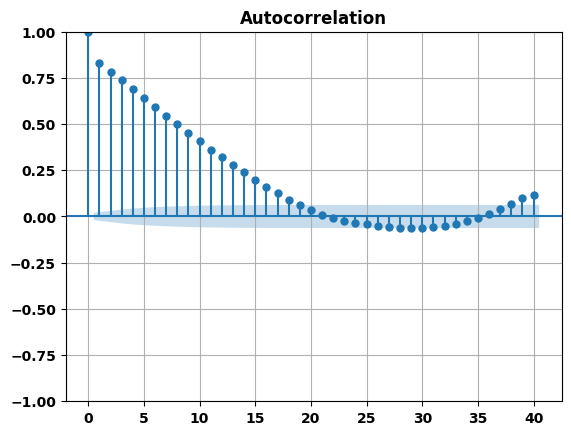

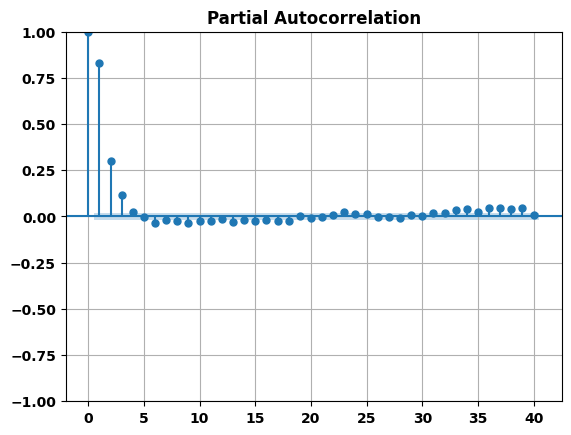

In [105]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

plot_acf(logins_15m_count["logins_15m_count"])
plt.grid()
plt.show()

plot_pacf(logins_15m_count["logins_15m_count"])
plt.grid()
plt.show()

In [106]:
results = adfuller(logins_15m_count["logins_15m_count"])
print(f"ADF Statistic: {results[0]:.3f}")
print(f"p-value: {results[1]:.3f}")
if results[1] < 0.05:
    print("The time series is stationary")
else:
    print("The time series is not stationary")

for key, value in results[4].items():
    print("Critical Values:")
    print(f"{key}, {value:.3f}")

ADF Statistic: -10.338
p-value: 0.000
The time series is stationary
Critical Values:
1%, -3.431
Critical Values:
5%, -2.862
Critical Values:
10%, -2.567


Given the p-value, we can conclude that this time series is stationary.
The ADF statistic is less than the critical value at 1%, 5%, and 10% confidence intervals, so we can reject the null hypothesis that a unit root is present in the time series.

From the AutoCorrelation plot, there is a gradual decrease in the correlation as the lag increases, which suggest a possibel moving averagge component

In [107]:
arma_model = ARIMA(logins_15m_count["logins_15m_count"], order=(0, 1, 1))
arma_res = arma_model.fit()

print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:       logins_15m_count   No. Observations:                 9788
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -28507.944
Date:                Thu, 01 Feb 2024   AIC                          57019.888
Time:                        20:08:58   BIC                          57034.266
Sample:                    01-01-1970   HQIC                         57024.760
                         - 04-13-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4271      0.006    -70.251      0.000      -0.439      -0.415
sigma2        19.8415      0.168    117.861      0.000      19.512      20.171
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [108]:
arma_model = ARIMA(logins_15m_count["logins_15m_count"], order=(1, 0, 1))
arma_res = arma_model.fit()

print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:       logins_15m_count   No. Observations:                 9788
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -28370.047
Date:                Thu, 01 Feb 2024   AIC                          56748.093
Time:                        20:08:59   BIC                          56776.849
Sample:                    01-01-1970   HQIC                         56757.837
                         - 04-13-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5149      0.567     16.785      0.000       8.404      10.626
ar.L1          0.9393      0.003    325.753      0.000       0.934       0.945
ma.L1         -0.3863      0.007    -52.486      0.0

Ljung-Box (L1) (Q): This is a test statistic for the null hypothesis that the residuals from the ARIMA model have no autocorrelation. In this case, the p-value (Prob(Q)) is greater than 0.05, indicating that you fail to reject the null hypothesis of no autocorrelation. The error are random which is good.

Jarque-Bera (JB): This is a test statistic for the null hypothesis that the residuals from the ARIMA model are normally distributed. In this case, the p-value (Prob(JB)) is less than 0.05, indicating that you reject the null hypothesis of normality. This means that the residuals are not normally distributed.

Heteroskedasticity (H): This is a test statistic for the null hypothesis that the residuals from the ARIMA model have constant variance (homoskedasticity). In this case, the p-value (Prob(H)) is less than 0.05, indicating that you reject the null hypothesis of homoskedasticity. The residuals are heteroskedastic, meaning the variance changes with the level of the variable.

This suggests that 
- the residuals are not autocorrelated which is good 
- they are not normally distributed and 
- they have changing variance.

In [ ]:
import pmdarima as pm

model = pm.auto_arima(
    logins_15m_count["logins_15m_count"], seasonal=False, trace=True)

In [ ]:
forecast = model.fit_predict(
    start=len(logins_15m_count), end=len(logins_15m_count) + 10
)

### Part 2: Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?,/br>
**Answer**: </br>
*The key measure of success would be the increase in the number of driver partners who cross the bridge (cross-city trip). This is because the goal of the experiment is to encourage driver partners to be available in both cities, and the increase in number of drivers who cross the bridge would be a direct measure of success. 

This is a good metric because it is 
- Specific: directly measures the behavior we want to influence
- Measureable: Can be tracked and quantified 
- Relevant: directly relates to the goal of the experiment
- Actionable: if we see that there is an increase in cross-city trips suggesting that the reimbursement is effective this can easily be continued or expanded*

2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success.

Please provide details on:
- a. how you will implement the experiment</br>
**Answer**: </br>
*The experiment would be implemented by randomly selecting a group of driver partners from the entire pool off drivers to monitor. The sample should be random as to try to be representative of the population. This group can then be split into two equal groups. One group, the experimental group would be reimbursed for all tolls cost in a hassle free manner. The second group, the control group would continue to operate as usual without any changes. We can then measure and compare the cross-city trips made between both groups.

The experiment would be run for a period of 3 month period (12 months ideally), to avoid any influence of seasonal changes.*</br>
- b. what statistical test(s) you will conduct to verify the significance of the observation</br>
**Answer**: </br>
*The statistical test that would be conducted to verify the significance of the observation would be a t-test. We would use the T test to compare the means of the two groups and determine if there is a significant difference.*</br>


- c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.</br>
**Answer**: </br>
*The results would help us understand whether reimbursing all toll costs had a significant effect on the number of cross-city trips. If the P-value is below a certain threshold (e.g. 0.05), we could conclude that the toll reimbursement is effective, and reject the null hypothesis. 

Some caveats:
- correlation does not imply causation. 
- other factors could be influencing the results and the experiment will not be able to prove that the toll reimbursement is the sole and primary cause of any increase in cross-city trips*